In [1]:
'''
this one is smart auto encoder, with padding
'''


'\nthis one is smart auto encoder, with padding\n'

In [2]:
import os
import cv2

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# root_path = r'gdrive/My Drive/work/research/AutoEncoder_classification/'  #change dir to your project folder
# import os
# os.chdir(root_path)

In [4]:

from tensorflow.keras.datasets import cifar10


import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Cropping2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [5]:
import matplotlib.pyplot as plt

### 01 Get the data

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train])
# x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])

print(x_train.shape)

(50000, 32, 32, 3)


In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


In [8]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


#### 01a Pad the train data with -1 for left hand side

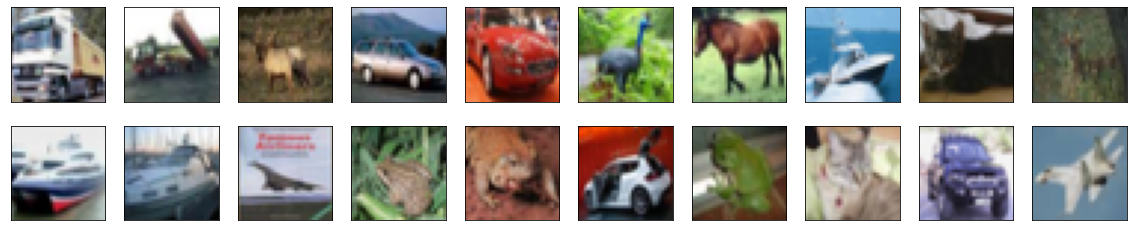

In [9]:
# before padding

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i])

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
# a=[[1,2,3,4],
#    [5,6,7,8]]
# a=np.array(a)
# print(a.shape)
# col_padding=(2,2)
# row_padding=(2,2)
# np.pad(a,(col_padding,row_padding),'constant',constant_values=(-1))

In [10]:
perc=0.2
pad=int(perc*x_train[0].shape[1])
print("Number of rows on both sides = ",pad)
padding_val=127/255

denom=max(y_train)-min(y_train)
print(denom)



Number of rows on both sides =  6
[9]


In [11]:
def pad_single_channel(matrix,col_padding,row_padding,values):
    all_padded=[]
    for i in range(matrix.shape[0]):
        new_mat=np.pad(matrix[i],(col_padding,row_padding),'constant',constant_values=(values[i]))
        all_padded.append(new_mat)
    all_padded=np.array(all_padded)
    return all_padded
        

In [12]:
def pad_multi(matrix,col_padding, row_padding,values):
    '''
    matrix shape: count X rows X columns X channels
    col_padding: (left_padding, right_padding)
    row_padding: (up_padding, below_padding)
    value: value to pad with
    '''
#     b=np.pad(a, ((1,1), (1,1), (0,0)), mode='constant',constant_values=(9))

    all_padded=[]
    for i in range(matrix.shape[0]):
        new_padded=np.pad(matrix[i],(col_padding,row_padding,(0,0)),'constant',constant_values=(values[i]))
#         this_padded.append(np.pad(matrix[i][0],padding_length,'constant',constant_values=(values[i])))
#         this_padded.append(np.pad(matrix[i][1],padding_length,'constant',constant_values=(values[i])))
#         this_padded.append(np.pad(matrix[i][2],padding_length,'constant',constant_values=(values[i])))        
        all_padded.append(new_padded)
    all_padded=np.array(all_padded)
    return all_padded
        
        

In [13]:
values=[padding_val for i in range(x_train.shape[0])]
# x_train_left=pad_multi(x_train,(pad,pad),(pad,pad),values)

x_train_left=pad_multi(x_train,(pad,pad),(pad,pad),values)
# rows=x_train_left.shape[1]
# cols=x_train_left.shape[2]

# x_train_left=x_train_left.reshape(len(x_train_left),rows,cols,1)
print(x_train_left.shape)
# x_train_left = np.reshape(x_train_left, (len(x_train_left), 30, 30, 1))


(50000, 44, 44, 3)


In [14]:
print(x_train[0].shape,x_train_left[0].shape)

(32, 32, 3) (44, 44, 3)


#### 01b Pad the train data with y_values for right hand side

In [15]:
val=[y_train[i]/denom for i in range(y_train.shape[0])]
x_train_right=pad_multi(x_train,(pad,pad),(pad,pad),val)



# rows=x_train_right.shape[1]
# cols=x_train_right.shape[2]
# print(rows,cols)


# x_train_right=x_train_right.reshape(len(x_train_right),rows,cols,1)

print(x_train_right.shape)

(50000, 44, 44, 3)


#### 01c Pad the test data with padding_val for left hand side

In [16]:
values=[padding_val for i in range(x_test.shape[0])]
x_test_left=pad_multi(x_test,(pad,pad),(pad,pad),values)

# rows=x_test_left.shape[1]
# cols=x_test_left.shape[2]
# print(rows,cols)


# x_test_left=x_test_left.reshape(len(x_test_left),rows,cols,1)
print(x_test_left.shape)

(10000, 44, 44, 3)


#### 01d Pad the test data with y values for right hand side

In [17]:
x_test_right=[]
val=[y_test[i]/denom for i in range(y_test.shape[0])]
x_test_right=pad_multi(x_test,(pad,pad),(pad,pad),val)

# rows=x_test_right.shape[1]
# cols=x_test_right.shape[2]
# print(rows,cols)

# x_test_right=x_test_right.reshape(len(x_test_right),rows,cols,1)
print(x_test_right.shape)    

(10000, 44, 44, 3)


#### 01e Check the padding

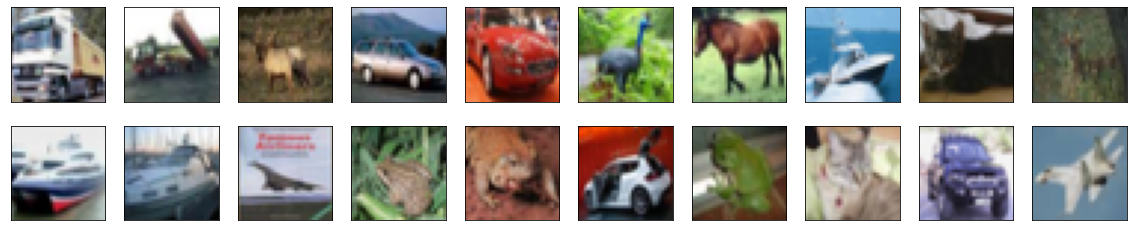

In [19]:
# before padding

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


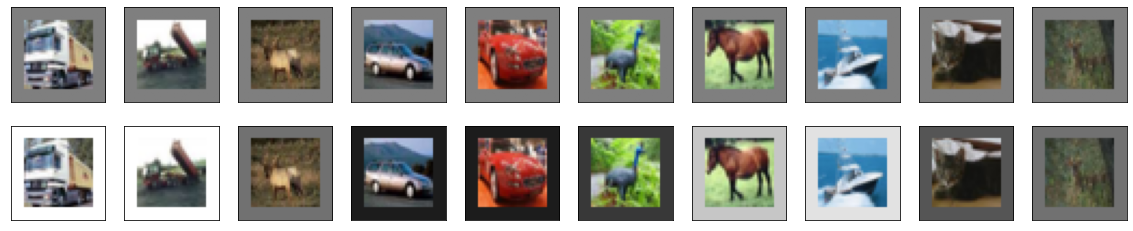

In [21]:
# after padding

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
#     print(x_train_right[i].shape)
    plt.imshow(x_train_left[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_train_right[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### 02 Create and train the model

In [ ]:
input_img = keras.Input(shape=x_train_left[0].shape)

x = layers.Conv2D(32, (3, 3),strides=1, activation='relu', padding='same')(input_img)
x = layers.BatchNormalization() (x)
x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
encoded = layers.BatchNormalization() (x)

# encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2,2))(encoded)
x = layers.Conv2D(32, (3, 3),strides=1, activation='relu',padding='same')(x)
x = layers.BatchNormalization() (x)

decoded = layers.Conv2D(3, (1, 1),strides=1, activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
autoencoder.summary()

In [ ]:
autoencoder.summary()

In [ ]:
from keras.callbacks import TensorBoard

history=autoencoder.fit(x_train_left, x_train_right,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_left, x_test_right))


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
decoded_imgs = autoencoder.predict(x_test_left)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_right[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
# decoded_imgs[0][9]

In [ ]:
autoencoder.save("models/autoencoder_with_label.h")

In [ ]:
new_autoenc=load_model("models/autoencoder_with_label.h")

In [ ]:
decoded_imgs = new_autoenc.predict(x_test_left)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_right[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
decoded_imgs = new_autoenc.predict(x_test_left)

n = 5
plt.figure(figsize=(10, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_right[i])
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# plt.savefig("figures/decodedvsoriginal.svg")


### 03 Extract features and test with LogReg

In [ ]:
encoder = Model(inputs=input_img, outputs=encoded)
encoder.save('models/encoder_with_label.h5')

In [ ]:
def flatten_encoded_images_for_logreg(X_array):
    print(X_array.shape)
    X_array_flattened=[]
    for i in range(X_array.shape[0]):
        X_array_flattened.append(X_array[i].flatten())
    X_array_flattened=np.array(X_array_flattened)
    print("Shape is ",X_array_flattened.shape)
    return X_array_flattened

In [ ]:
# load the model from file
encoder = load_model('models/encoder_with_label.h5')
# encode the train data
x_train_encode = encoder.predict(x_train_left)
x_train_encode_flat=flatten_encoded_images_for_logreg(x_train_encode)

# x_train_encode=x_train_encode.flatten()
print("Shape of encoded flat",x_train_encode_flat.shape)
# encode the test data
x_test_encode = encoder.predict(x_test_left)
x_test_encode_flat=flatten_encoded_images_for_logreg(x_test_encode)
print("Shape of encoded flat",x_test_encode.shape)



In [ ]:
# define the model
model = LogisticRegression()
# fit the model on the training set
model.fit(x_train_encode_flat, y_train)
# make predictions on the test set
yhat = model.predict(x_test_encode_flat)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

### 04 Extract features and Test with a CNN

In [ ]:
# https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

#### 04a Convert y values to categorical

In [ ]:
#one-hot encode target column
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_train_one_hot.shape,y_test_one_hot.shape)

#### 04b Extract features using encoder

In [ ]:
# load the model from file
encoder = load_model('models/encoder_with_label.h5')
# encode the train data
x_train_encode = encoder.predict(x_train_left)
print("Shape of training encoded images",x_train_encode.shape)

# encode the test data
x_test_encode = encoder.predict(x_test_left)
print("Shape of testing encoded images",x_test_encode.shape)


In [ ]:
print(x_train_encode[0].shape,x_test_encode[1].shape)

### 04c create a CNN that takes encoded image as input

In [ ]:
def get_model(x_train):
    # define a CNN to make the predictions
    #create model
    model = Sequential()#add model layers
    model.add(Conv2D(24, kernel_size=5, padding="same", activation='relu', input_shape=x_train[0].shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=5, padding="same", activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=5, padding="same", activation='relu'))
    model.add(MaxPool2D(padding='same'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])    
    return model
    

def define_model_VGG3(x_train):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=x_train[0].shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
acc_list=[]
for i in range(10):
    model=define_model_VGG3(x_train_encode)
    # print(model.summary())
    #train the model
    num_epochs=100
    history=model.fit(x_train_encode, y_train_one_hot, validation_data=(x_test_encode, y_test_one_hot), epochs=num_epochs,verbose=0)
    loss,acc=model.evaluate(x_test_encode, y_test_one_hot)
    print("Accuracy is ",acc)
    acc_list.append(acc)


In [ ]:
print(sum(acc_list)/len(acc_list))


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
acc_list=[]
for i in range(20):
    model=get_model(x_train_encode)
    # print(model.summary())
    #train the model
    num_epochs=40
    history=model.fit(x_train_encode, y_train_one_hot, validation_data=(x_test_encode, y_test_one_hot), epochs=num_epochs,verbose=0)
    loss,acc=model.evaluate(x_test_encode, y_test_one_hot)
    print("Accuracy is ",acc)
    acc_list.append(acc)